# Analyzing SEC 10-K Corporate Filings: A FinBERT Approach

***

## Table of Contents

[1. Scraping and Cleaning SEC Filings](#scraping)

>[1.1. Retriving 'Management Discussion & Analysis' Parts of SEC 10-K Filings](#mda)

[2. Fine-Tuning a Model](#finetune)

>[2.1. Preprocessing](#prep)

>[2.2. Train-Test Split](#tts)

>[2.3. Training the Model](#train)

>[2.4. Evaluate and Save the Model](#eval)

[3. Applying Fine-Tuned and Untuned FinBERT on SEC Filings](#apply)

>[3.1. Untuned FinBERT](#untuned)

>[3.2. Fine-tuned FinBERT](#finetuned)

[4. Feature Extraction](#featureextraction)

>[4.1. With Random Forest Classifer](#feature)

>[4.2. With Vanilla Neural Network](#feature2)

***

If you intend to run this notebook on Google Colab, you can use the following code snippet to install the required packages:

In [ ]:
import os
IS_ON_COLAB = bool(os.getenv("COLAB_RELEASE_TAG"))

if IS_ON_COLAB:
  !pip install transformers transformers[torch] tokenizers datasets sentencepiece huggingface_hub[cli] xformers accelerate sec_api

In [1]:
# import required libraries
from transformers import BertTokenizer, BertConfig, BertModel, AutoModelForSequenceClassification, BertForSequenceClassification, pipeline, AutoModel, AutoTokenizer, TrainingArguments, Trainer
from datasets import load_dataset, Dataset, DatasetDict
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import f1_score, classification_report, confusion_matrix, accuracy_score, f1_score, precision_score, recall_score
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim.lr_scheduler import StepLR
from torch.utils.data import DataLoader, TensorDataset
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import re
#from google.colab import files
import io
from sec_api import ExtractorApi

ModuleNotFoundError: No module named 'transformers'

## 1. Scraping and Cleaning SEC Filings <a class="anchor" id="scraping"></a>

### 1.1. Retriving 'Management Discussion & Analysis' Parts of SEC 10-K Filings <a class="anchor" id="mda"></a>

This code chunk here is presented for demonstration, without a valid API key, it will not work.

In [ ]:
# you need to replace your API key to access sec-api.io (detailed description in README.md)
API_KEY = "API-KEY"

# to initiate extractorAPI for the purpose of retriving data
extractorApi = ExtractorApi(API_KEY)

# to read filing URLs and store them in a `list`
with open('filings_urls.txt', 'r') as file:
    filing_10_k_urls = [line.strip() for line in file if line.strip()]

# (optional) to display the list of all filing URLs
print(filing_10_k_urls)

# to initiate empty list to store extracted 10-K filings
extracted_data = []

# to iterate over the list of filing URLs
for index, filing_10_k_url in enumerate(filing_10_k_urls, start=1):
    # `7` corresponds the "Management's Discussion & Analysis" part
    # `text` corresponds text format for extracted data instead of .html file
    item_7_text = extractorApi.get_section(filing_10_k_url, '7', 'text')

    # append list to have a complete dataset
    extracted_data.append({
        'URL': filing_10_k_url,
        'MD&A': item_7_text
    })

    # to follow each increment of successful extraction
    print(f"MD&A part of Filing {index} is extracted and appended.")

# to create a Pandas DataFrame with the extracted MD&A sections
mda_df = pd.DataFrame(extracted_data)

In [ ]:
def clean_text(text):
    """
    Clean up a text by removing specific patterns using regular expressions.

    This function takes a text input and applies a series of regular expressions
    to remove specific patterns (HTML and XML) commonly found in text extracted from filings.

    Args:
        text (str): The input text to be cleaned.

    Returns:
        str: The cleaned text with specified patterns removed.
    """
    # list of regex patterns to be removed from the text
    patterns = [
        r'##TABLE_END',          # remove "##TABLE_END"
        r'##TABLE_START',        # remove "##TABLE_START"
        r'&#160;',               # remove "&#160;"          (Non-breaking space)
        r'&#8226;',              # remove "&#8226;"         (Bullet point)
        r'&#8220; &#8221;',      # remove "&#8220; &#8221;" (Quotation marks)
        r'&#8220;&#8212;',       # Remove "&#8220;&#8212;"  (Quotation dash)
        r'&#8220;',              # remove "&#8220;"         (Opening double quotation mark)
        r'&#8221;',              # remove "&#8221;"         (Closing double quotation mark)
        r'&#8212;',              # remove "&#8212;"         (Em dash)
        r'&#8217;',              # remove "&#8217;"         (Right single quotation mark)
        r'&#59;',                # remove "&#59";           (Semicolon)
        r'&#9679;',              # remove "&#9679;"         (Bullet point)
        r'&#8203;',              # remove "&#8203;"         (Zero-width space)
        r'&#8211;',              # remove "&#8211;"         (En dash)
        r'&#34;',                # remove "&#34;"           (Double quotation mark)
        r'#38;',                 # remove "#38;"            (Ampersand)
        r'&#8729;',              # remove "&#8729;"         (Middle dot)
        r'\n+'                   # remove any consecutive newline characters

    ]

    # to compile regex patterns into a list of regex objects
    regex_patterns = [re.compile(pattern) for pattern in patterns]

    # to apply each regex pattern to the text and replace matches with an empty string
    cleaned_text = text
    for pattern in regex_patterns:
        cleaned_text = pattern.sub('', cleaned_text)

    return cleaned_text

In [ ]:
# to apply the user-defined clean_text function to the extracted text data to clean it
mda_df['MD&A'] = mda_df['MD&A'].apply(clean_text)

In [ ]:
def truncate_text(df, column_name, max_chars=20000):
    """
    Truncate text in a DataFrame column to a specified maximum number of characters.

    This function truncates the text in the specified column of the provided DataFrame
    to a maximum length defined by the 'max_chars' parameter.

    Args:
        df (pandas.DataFrame):     The DataFrame containing the text column to be truncated.
        column_name (str):         The name of the column containing the text to be truncated.
        max_chars (int, optional): The maximum number of characters to retain in each text.
                                   Default is 20000.

    Returns:
        pandas.DataFrame: The modified DataFrame with truncated text in the specified column.
    """
    # truncate the text in the specified column to the maximum character limit
    df[column_name] = df[column_name].str[-max_chars:]
    return df

In [ ]:
# truncate text such that decrease computational cost
truncate_text(mda_df, 'MD&A')

In [ ]:
# list of labels by hand
labels = [np.nan, np.nan, np.nan, np.nan, np.nan, np.nan, np.nan, np.nan, np.nan, np.nan,
          2, 0, 0, 1, 0, 0, 1, 1, 2, 1,
          np.nan, np.nan, np.nan, np.nan, np.nan, np.nan, np.nan, np.nan, np.nan, np.nan,
          np.nan, np.nan, np.nan, np.nan, np.nan, np.nan, np.nan, np.nan, np.nan, np.nan,
          np.nan, np.nan, np.nan, np.nan, np.nan, np.nan, np.nan, np.nan, np.nan, np.nan,
          np.nan, np.nan, np.nan, np.nan, np.nan, np.nan, np.nan, np.nan, np.nan, np.nan,
          0, 1, 0, 0, 1, 2, 0, 0, 1, 1]

# add 330 more np.nan such that it is equal to the number of rows in df
labels.extend([np.nan] * 330)

# to create empty column called `label` to store labels by hand
mda_df['label'] = labels

In [ ]:
# to export the merged DataFrame as a pickle file (considering RAM efficiency) and parquet file
mda_df.to_pickle("data/filings.pkl")
mda_df.to_parquet("data/filings.gzip",
                  compression="gzip")

## 2. Fine-Tuning a Model <a class="anchor" id="finetune"></a>

In [ ]:
# to check if GPU is available or not
if torch.cuda.is_available():
    device = torch.device("cuda")
    print(f'GPU is available and the device is {torch.cuda.get_device_name(0)}.')

else:
    device = torch.device("cpu")
    print('No GPU available, using the CPU.')

GPU is available and the device is Tesla T4.


In [ ]:
# to load the `financial_phrasebank` dataset for fine-tuning of FinBERT model
dataset = load_dataset("financial_phrasebank", "sentences_75agree")

Generating train split:   0%|          | 0/3453 [00:00<?, ? examples/s]

### 2. 1. Preprocessing <a class="anchor" id="prep"></a>

In [ ]:
dataset.set_format(None)

def label_to_sentiment(row):
    """
    Convert numeric labels into verbal sentiments for a given row in a dataset.

    This function converts a numeric label within a dataset row into a verbal sentiment using a
    predefined mapping that correlates numeric labels with corresponding verbal sentiments
    such as "neutral," "positive," and "negative."

    Args:
        row (dict): A dictionary representing a row in a dataset, with a "label" key.

    Returns:
        dict: The input row dictionary with an additional "sentiment" key that holds
              the verbal sentiment corresponding to the numeric label.
    """
    # mapping of numeric labels to verbal sentiments
    translation = {
        0: "neutral",
        1: "positive",
        2: "negative",
    }

    # retrieve the numeric label from the row and map it to a verbal sentiment
    row["sentiment"] = translation[row["label"]]
    return row

# mapping function to Dataset
dataset_with_sentiments = dataset.map(label_to_sentiment)

Map:   0%|          | 0/3453 [00:00<?, ? examples/s]

In [ ]:
# for visual inspection to check that `label_to_sentiment` function works properly
dataset_with_sentiments["train"][0]

{'sentence': 'According to Gran , the company has no plans to move all production to Russia , although that is where the company is growing .',
 'label': 1,
 'sentiment': 'positive'}

In [ ]:
# to initialize a tokenizer from the 'yiyanghkust/finbert-tone'
tokenizer = BertTokenizer.from_pretrained(
    'yiyanghkust/finbert-tone',
    do_lower_case = True
    )

In [ ]:
def tokenize_for_finetuning(batch):
    """
    Tokenize a batch of sentences using a tokenizer. The resulting tokenized sequences
    are returned as PyTorch tensors along with their corresponding attention masks.

    Args:
        batch (dict): A dictionary representing a batch of sentences with a "sentence" key.

    Returns:
        dict: A dictionary containing the tokenized sequences as PyTorch tensors along with
              their attention masks. Keys are "input_ids," "attention_mask," and "token_type_ids."
    """
    # tokenize the sentences in the batch
    return tokenizer(batch["sentence"],
                     padding=True,                # pad sequences to the same length
                     truncation=True,             # truncate sequences if they exceed the maximum length
                     add_special_tokens=True,     # add special tokens like [CLS] and [SEP]
                     pad_to_max_length=True,      # pad to the maximum length in the batch
                     return_attention_mask=True,  # return attention masks for each token
                     return_tensors='pt')         # return PyTorch tensors

# to apply user-defined `tokenize` function using `DatasetDict.map`
dataset_encoded = dataset.map(tokenize_for_finetuning,
                              batched=True,
                              batch_size=None)

# to determine the format of the encoded dataset to use PyTorch tensors
dataset_encoded.set_format(
    "torch",
    columns=["input_ids", "attention_mask", "label"],
)

# to display names of features and number of rows in encoded dataset
dataset_encoded

Map:   0%|          | 0/3453 [00:00<?, ? examples/s]

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2441: UserWarning: Though `pad_to_max_length` = `True`, it is ignored because `padding`=`True`.
  warnings.warn("Though `pad_to_max_length` = `True`, it is ignored because `padding`=`True`.")
Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


DatasetDict({
    train: Dataset({
        features: ['sentence', 'label', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 3453
    })
})

In [ ]:
print(f"""Type of dataset is {type(dataset_with_sentiments)} and,\nType of encoded dataset is {type(dataset_encoded)}.
Shape of the dataset is {dataset.shape}\n{dataset.cache_files}.
""")

Type of dataset is <class 'datasets.dataset_dict.DatasetDict'> and,
Type of encoded dataset is <class 'datasets.dataset_dict.DatasetDict'>.
Shape of the dataset is {'train': (3453, 2)}
{'train': [{'filename': '/root/.cache/huggingface/datasets/financial_phrasebank/sentences_75agree/1.0.0/550bde12e6c30e2674da973a55f57edde5181d53f5a5a34c1531c53f93b7e141/financial_phrasebank-train.arrow'}]}.



### 2. 2. Train-Test Split <a class="anchor" id="tts"></a>


In [ ]:
# to set the format of the encoded dataset to use pandas DataFrames
dataset_encoded.set_format(type="pandas")

# to split the dataset into train and test sets using stratified sampling
ds_train, ds_test, = train_test_split(dataset_encoded["train"], stratify=dataset_encoded["train"]["label"], test_size=0.2, random_state=44)

# to further split the training set into training and validation sets
ds_train, ds_val = train_test_split(ds_train, stratify=ds_train["label"],test_size=0.2, random_state=44)

print(f"The shapes of train, test, and validations sets are {ds_train.shape}, {ds_test.shape}, {ds_val.shape}, respectively.")

The shapes of train, test, and validations sets are (2209, 5), (691, 5), (553, 5), respectively.


In [ ]:
# to set the format of the training, test, and validation sets to use PyTorch tensors

ds_train = Dataset.from_pandas(ds_train)
ds_train.set_format(type="torch")

ds_test = Dataset.from_pandas(ds_test)
ds_test.set_format(type="torch")

ds_val = Dataset.from_pandas(ds_val)
ds_val.set_format(type="torch")

### 2. 3. Training the Model <a class="anchor" id="train"></a>

In [ ]:
# to initialize a pre-trained BERT model for sequence classification
model = BertForSequenceClassification.from_pretrained(
    'yiyanghkust/finbert-pretrain',
    num_labels = 3
    )

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at yiyanghkust/finbert-pretrain and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
# to define a function to compute evaluation metrics for classification
def compute_metrics(eval_pred):
    """
    Compute accuracy metric for classification evaluation.

    Args:
        eval_pred (tuple): A tuple containing predicted probabilities and true labels.

    Returns:
        dict: A dictionary containing the computed accuracy metric.
    """
    predictions, labels = eval_pred
    predictions = np.argmax(predictions, axis=1)
    return {'accuracy' : accuracy_score(predictions, labels)}

# define training arguments for the `Trainer`
args = TrainingArguments(
    output_dir='temp/',                    # directory to save model checkpoints and logs
    evaluation_strategy='epoch',           # evaluate at the end of each epoch
    save_strategy='epoch',                 # save model checkpoints at the end of each epoch
    optim="adamw_torch",                   # set the optimizer to train as "adamw"
    learning_rate=1e-5,                    # learning rate for optimization
    per_device_train_batch_size=64,        # batch size for training
    per_device_eval_batch_size=64,         # batch size for evaluation
    num_train_epochs=5,                    # number of training epochs
    weight_decay=0.01,                     # weight decay for regularization
    load_best_model_at_end=True,           # load the best model at the end of training
    metric_for_best_model='accuracy',      # metric to determine the best model
)

# to initialize a `Trainer` for training and evaluation
trainer = Trainer(
    model=model,
    args=args,
    train_dataset=ds_train,
    eval_dataset=ds_val,
    compute_metrics=compute_metrics,
)

# to train the model using the `Trainer`
trainer.train()

Epoch,Training Loss,Validation Loss,Accuracy
1,No log,0.601808,0.725136
2,No log,0.346899,0.884268
3,No log,0.270539,0.913201
4,No log,0.249910,0.911392
5,No log,0.248187,0.918626


TrainOutput(global_step=175, training_loss=0.3708878435407366, metrics={'train_runtime': 270.5091, 'train_samples_per_second': 40.83, 'train_steps_per_second': 0.647, 'total_flos': 760577639921820.0, 'train_loss': 0.3708878435407366, 'epoch': 5.0})

### 2. 4. Evaluate and Save the Model <a class="anchor" id="eval"></a>

In [ ]:
# to use `Trainer` to predict on the test dataset and retrieve evaluation metrics
trainer.predict(ds_test).metrics

{'test_loss': 0.21604694426059723,
 'test_accuracy': 0.9232995658465991,
 'test_runtime': 5.1193,
 'test_samples_per_second': 134.98,
 'test_steps_per_second': 2.149}

In [ ]:
# to evaluate the model
results = trainer.evaluate()
print(results)

# to save the fine-tuned model
trainer.save_model('finbert-sentiment/')

{'eval_loss': 0.2481873482465744, 'eval_accuracy': 0.918625678119349, 'eval_runtime': 3.9473, 'eval_samples_per_second': 140.096, 'eval_steps_per_second': 2.28, 'epoch': 5.0}


In [ ]:
torch.cuda.empty_cache()

## 3. Applying Fine-Tuned and Untuned FinBERT on SEC Filings <a class="anchor" id="apply"></a>
If you are running this notebook on ***Google Colab***, use this code snippet to import `filings.gzip`

In [ ]:
# to upload files from local machine to Google Colab, and...
uploaded = files.upload()

# to read the uploaded pickle file using Pandas and load it into `data`
data = pd.read_parquet(io.BytesIO(uploaded['521.gzip']))

Saving 521.gzip to 521.gzip


If you are running this notebook on ***your local machine***, use this code snippet to import `filings.gzip`

In [ ]:
data = pd.read_parquet("../data/filings.gzip")

***

In [ ]:
def get_input_ids_and_attention_mask_chunk(tokens):
    """
    Process tokens into input IDs and attention masks using a sliding window approach.

    This function overcomes the maximum length limitation of 512 tokens in FinBERT by
    applying a sliding window approach. It takes tokenized data as input and processes
    it into input IDs and attention masks in chunks, each within the maximum length.

    Args:
        tokens (dict): A dictionary containing tokenized data with "input_ids" and "attention_mask" keys.

    Returns:
        tuple: A tuple containing lists of input IDs and attention masks for each chunk.
    """
    chunksize = 512      # maximum chunk size for BERT
    input_id_chunks = list(tokens['input_ids'][0].split(chunksize - 2))
    attention_mask_chunks = list(tokens['attention_mask'][0].split(chunksize - 2))

    for i in range(len(input_id_chunks)):

        # to add [CLS] and [SEP] tokens to the start and end of each chunk
        input_id_chunks[i] = torch.cat([
            torch.tensor([101]).to(device), input_id_chunks[i].to(device), torch.tensor([102]).to(device)
        ])

        # to generate attention mask for the chunk with [CLS] and [SEP]
        attention_mask_chunks[i] = torch.cat([
            torch.tensor([1]).to(device), attention_mask_chunks[i].to(device), torch.tensor([1]).to(device)
        ]).to(device)

        # to calculate the pad length required for the chunk
        pad_length = chunksize - input_id_chunks[i].shape[0]

        # to pad the chunk with zeros if necessary in the last chunk
        if pad_length > 0:
            input_id_chunks[i] = torch.cat([
                input_id_chunks[i], torch.Tensor([0] * pad_length).to(device)
            ])
            attention_mask_chunks[i] = torch.cat([
                attention_mask_chunks[i], torch.Tensor([0] * pad_length).to(device)
            ])

    return input_id_chunks, attention_mask_chunks

### 3.1. Untuned FinBERT <a class="anchor" id="untuned"></a>

#### 3.1.1. Untuned FinBERT on SEC 10-K Filings <a class="anchor" id="untuned1"></a>

In [ ]:
untuned_model = BertForSequenceClassification.from_pretrained('yiyanghkust/finbert-tone',num_labels=3)

In [ ]:
# a for loop through each row in data
for index, row in data.iterrows():
    # to tokenize the MD&A text using the tokenizer
    tokens = tokenizer.encode_plus(row['MD&A'],
                                   add_special_tokens=False,
                                   return_tensors='pt'
                                   ).to('cuda')

    # to split tokens into chunks for sliding window purpose
    input_ids_chunks, attention_mask_chunks = get_input_ids_and_attention_mask_chunk(tokens)

    # to use PyTorch's to stack input IDs and attention masks
    input_ids = torch.stack(input_ids_chunks)
    attention_mask = torch.stack(attention_mask_chunks)

    # to create dictionary as model input
    input_dict = {
        'input_ids': input_ids.long(),
        'attention_mask': attention_mask.int()
    }

    # just to be sure that the model is on GPU
    untuned_model.to('cuda')

    # to get model output and compute softmax probabilities
    output = untuned_model(**input_dict)
    probs = torch.nn.functional.softmax(output.logits, dim=-1)
    mean_probs = probs.mean(dim=0)

    # to get the predicted_sentiment using argmax
    predicted_sentiment = torch.argmax(mean_probs).item()

    # to append the predicted sentiment to the `prediction` column
    data.loc[index, 'untuned_prediction'] = predicted_sentiment

    # to print a message for every 10 iteration
    if (index + 1) % 10 == 0:
      print(f"Iteration {index + 1} Analyzed and prediction appended. Predicted Sentiment: {predicted_sentiment}")

Iteration 10 Analyzed and prediction appended. Predicted Sentiment: 0
Iteration 20 Analyzed and prediction appended. Predicted Sentiment: 0
Iteration 30 Analyzed and prediction appended. Predicted Sentiment: 0
Iteration 40 Analyzed and prediction appended. Predicted Sentiment: 0
Iteration 50 Analyzed and prediction appended. Predicted Sentiment: 0
Iteration 60 Analyzed and prediction appended. Predicted Sentiment: 0
Iteration 70 Analyzed and prediction appended. Predicted Sentiment: 0
Iteration 80 Analyzed and prediction appended. Predicted Sentiment: 0
Iteration 90 Analyzed and prediction appended. Predicted Sentiment: 0
Iteration 100 Analyzed and prediction appended. Predicted Sentiment: 0
Iteration 110 Analyzed and prediction appended. Predicted Sentiment: 0
Iteration 120 Analyzed and prediction appended. Predicted Sentiment: 0
Iteration 130 Analyzed and prediction appended. Predicted Sentiment: 0
Iteration 140 Analyzed and prediction appended. Predicted Sentiment: 0
Iteration 150 A

In [ ]:
# to take a subset such that label columns are non-missing for confusion matrix
subset = data.dropna(subset=['label'])

Confusion Matrix:


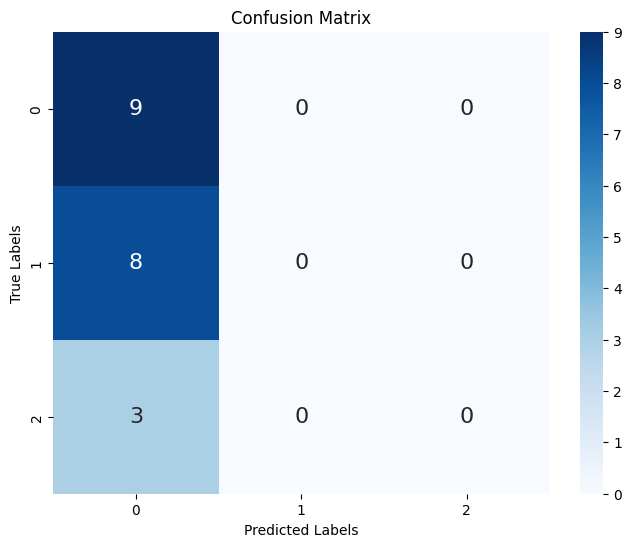

In [ ]:
cm = confusion_matrix(subset['label'], subset['untuned_prediction'])

# to create a confusion matrix heatmap to assess model accuracy
print("Confusion Matrix:")
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Reds", annot_kws={"size": 16})
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix")
plt.show()

In [ ]:
# to create a classification report to assess model accuracy
report = classification_report(subset['label'], subset['untuned_prediction'])
print("Classification Report:")
print(report)

Classification Report:
              precision    recall  f1-score   support

         0.0       0.45      1.00      0.62         9
         1.0       0.00      0.00      0.00         8
         2.0       0.00      0.00      0.00         3

    accuracy                           0.45        20
   macro avg       0.15      0.33      0.21        20
weighted avg       0.20      0.45      0.28        20



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


#### 3.1.2. Untuned FinBERT on 'Financial Phrasebank' <a class="anchor" id="untuned2"></a>

In [ ]:
dataset = load_dataset("financial_phrasebank", "sentences_75agree")

In [ ]:
def tokenize(batch):
    """
    Tokenize a batch of sentences using a tokenizer. The resulting tokenized sequences
    are returned as PyTorch tensors along with their corresponding attention masks.

    Args:
        batch (dict): A dictionary representing a batch of sentences with a "sentence" key.

    Returns:
        dict: A dictionary containing the tokenized sequences as PyTorch tensors along with
              their attention masks. Keys are "input_ids," "attention_mask," and "token_type_ids."
    """
    # tokenize the sentences in the batch
    return tokenizer(batch["sentence"],
                     padding=True,               # pad sequences to the same length
                     truncation=True             # truncate sequences if they exceed the maximum length
                     )

# to apply user-defined `tokenize` function using `DatasetDict.map`
dataset_encoded = dataset.map(tokenize,
                              batched=True,
                              batch_size=None)

In [ ]:
# to set the format of the encoded dataset to use pandas DataFrames
dataset_encoded.set_format(type="pandas")

# to split the dataset into train and test sets using stratified sampling
dataset_train, dataset_test = train_test_split(dataset_encoded["train"], stratify=dataset_encoded["train"]["label"], test_size=0.2, random_state=44)

print(f"The shapes of train, test, and validations sets are {dataset_train.shape}, {dataset_test.shape}, respectively.")

The shapes of train, test, and validations sets are (2762, 5), (691, 5), respectively.


In [ ]:
# mapping of dataset labels to model labels

# sentiment | financial_phrasebank | FinBERT
# ----------|----------------------|---------
# negative  |          0           |    2
# neutral   |          1           |    0
# positive  |          2           |    1

untuned_label_mapping = {0: 2, 1: 0, 2: 1}

# Apply label mapping to the dataset
dataset_test['label_for_untuned'] = dataset_test['label'].apply(lambda x: untuned_label_mapping.get(x))

In [ ]:
# to set the format of the training and test dataset in order to apply 'extract_states'
dataset_train = Dataset.from_pandas(dataset_train)
dataset_train.set_format(type="torch")
dataset_test = Dataset.from_pandas(dataset_test)
dataset_test.set_format(type="torch")

In [ ]:
# to extract required inputs to predict sentiments
input_ids_test      = dataset_test['input_ids']
token_type_ids_test = dataset_test['token_type_ids']
attention_mask_test = dataset_test['attention_mask']

In [ ]:
# to obtain logits then class probabilities applying softmax
with torch.no_grad():
    logits = untuned_model(input_ids=input_ids_test,
                           attention_mask=attention_mask_test
                           ).logits

probs = torch.nn.functional.softmax(logits, dim=1)


# to get predicted labels
predicted_labels = torch.argmax(probs, dim=1).cpu().numpy()

In [ ]:
# to calculate and print accuracy
accuracy = accuracy_score(dataset_test['label_for_untuned'], predicted_labels)
print(f"Accuracy: {accuracy:.2%}")

Accuracy: 86.69%


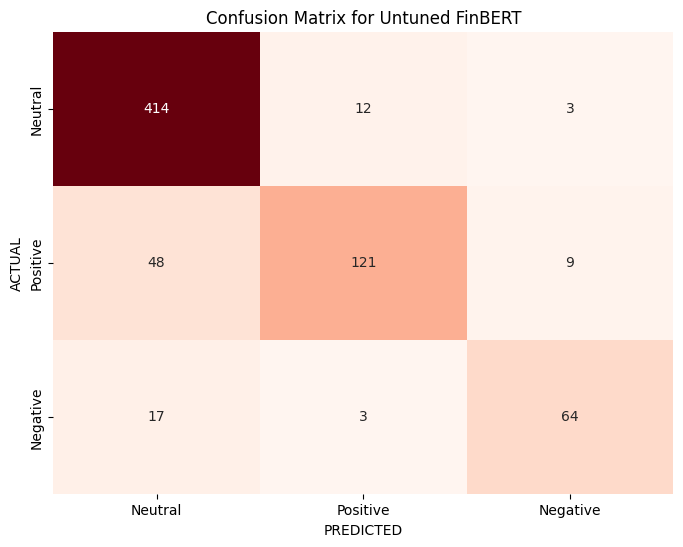

In [ ]:
# to create a confusion matrix
confusion = confusion_matrix(dataset_test['label_for_untuned'], predicted_labels)
plt.figure(figsize=(8, 6))
sns.heatmap(confusion, annot=True, fmt='d', cmap='Reds', cbar=False,
            xticklabels=["Neutral", "Positive", "Negative"],
            yticklabels=["Neutral", "Positive", "Negative"])
plt.xlabel('PREDICTED')
plt.ylabel('ACTUAL')
plt.title('Confusion Matrix for Untuned FinBERT')
plt.savefig('conf_mat_untuned.png')
plt.show()

### 3.2. Fine-tuned FinBERT <a class="anchor" id="finetuned"></a>

#### 3.2.1. Fine-tuned FinBERT on SEC 10-K Filings <a class="anchor" id="finetuned1"></a>

In [ ]:
finetuned_model = AutoModelForSequenceClassification.from_pretrained('finbert-sentiment/')

In [ ]:
# a for loop through each row in data
for index, row in data.iterrows():
    # to tokenize the MD&A text using the tokenizer
    tokens = tokenizer.encode_plus(row['MD&A'],
                                   add_special_tokens=False,
                                   return_tensors='pt'
                                   ).to(device)

    # to split tokens into chunks for sliding window purpose
    input_ids_chunks, attention_mask_chunks = get_input_ids_and_attention_mask_chunk(tokens)

    # to use PyTorch's to stack input IDs and attention masks
    input_ids = torch.stack(input_ids_chunks)
    attention_mask = torch.stack(attention_mask_chunks)

    # to create dictionary as model input
    input_dict = {
        'input_ids': input_ids.long(),
        'attention_mask': attention_mask.int()
    }

    # just to be sure that the model is on GPU
    finetuned_model.to('cuda')

    # to get model output and compute softmax probabilities
    output = finetuned_model(**input_dict)
    probs = torch.nn.functional.softmax(output.logits, dim=-1)
    mean_probs = probs.mean(dim=0)

    # to get the predicted_sentiment using argmax
    predicted_sentiment = torch.argmax(mean_probs).item()

    # to append the predicted sentiment to the `prediction` column
    data.loc[index, 'finetuned_prediction'] = predicted_sentiment

    # to print a message for every 10 iteration
    if (index + 1) % 10 == 0:
      print(f"Iteration {index + 1} Analyzed and prediction appended. Predicted Sentiment: {predicted_sentiment}")

Iteration 10 Analyzed and prediction appended. Predicted Sentiment: 1
Iteration 20 Analyzed and prediction appended. Predicted Sentiment: 1
Iteration 30 Analyzed and prediction appended. Predicted Sentiment: 1
Iteration 40 Analyzed and prediction appended. Predicted Sentiment: 1
Iteration 50 Analyzed and prediction appended. Predicted Sentiment: 1
Iteration 60 Analyzed and prediction appended. Predicted Sentiment: 1
Iteration 70 Analyzed and prediction appended. Predicted Sentiment: 1
Iteration 80 Analyzed and prediction appended. Predicted Sentiment: 1
Iteration 90 Analyzed and prediction appended. Predicted Sentiment: 1
Iteration 100 Analyzed and prediction appended. Predicted Sentiment: 1
Iteration 110 Analyzed and prediction appended. Predicted Sentiment: 1
Iteration 120 Analyzed and prediction appended. Predicted Sentiment: 1
Iteration 130 Analyzed and prediction appended. Predicted Sentiment: 1
Iteration 140 Analyzed and prediction appended. Predicted Sentiment: 1
Iteration 150 A

In [ ]:
# to take a subset such that label columns are non-missing for confusion matrix
subset = data.dropna(subset=['label'])

Confusion Matrix:


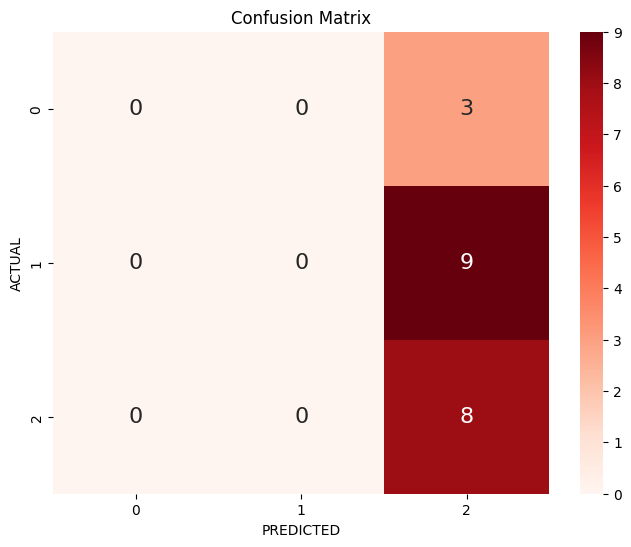

In [ ]:
cm = confusion_matrix(subset['label'], subset['finetuned_prediction'])

# to create a confusion matrix heatmap to assess model accuracy
print("Confusion Matrix:")
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Reds", annot_kws={"size": 16})
plt.xlabel("PREDICTED")
plt.ylabel("ACTUAL")
plt.title("Confusion Matrix")
plt.show()

In [ ]:
# to create a classification report to assess model accuracy
report = classification_report(subset['label'], subset['finetuned_prediction'])
print("Classification Report:")
print(report)

Classification Report:
              precision    recall  f1-score   support

         0.0       0.00      0.00      0.00         9
         1.0       0.40      1.00      0.57         8
         2.0       0.00      0.00      0.00         3

    accuracy                           0.40        20
   macro avg       0.13      0.33      0.19        20
weighted avg       0.16      0.40      0.23        20



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


#### 3.2.2. Fine-tuned FinBERT on 'Financial Phrasebank' <a class="anchor" id="finetuned1"></a>

In [ ]:
# to obtain logits then class probabilities applying softmax
with torch.no_grad():
    logits = finetuned_model(input_ids=input_ids_test,
                             attention_mask=attention_mask_test
                            ).logits

probs = torch.nn.functional.softmax(logits, dim=1)


# to get predicted labels
predicted_labels = torch.argmax(probs, dim=1).cpu().numpy()

In [ ]:
# to calculate and print accuracy
accuracy = accuracy_score(dataset_test["label"], predicted_labels)
print(f"Accuracy: {accuracy:.2%}")

Accuracy: 92.33%


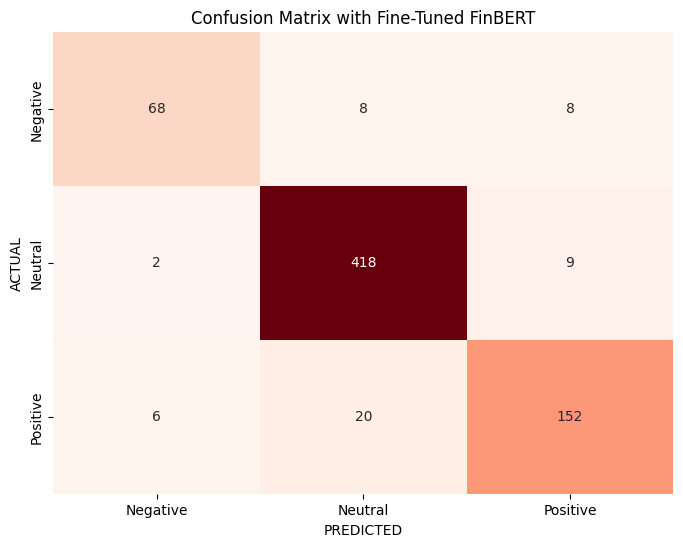

In [ ]:
# to create a confusion matrix
confusion = confusion_matrix(dataset_test["label"], predicted_labels)
plt.figure(figsize=(8, 6))
sns.heatmap(confusion, annot=True, fmt='d', cmap='Reds', cbar=False,
            xticklabels=["Negative", "Neutral", "Positive"],
            yticklabels=["Negative", "Neutral", "Positive"])
plt.xlabel('PREDICTED')
plt.ylabel('ACTUAL')
plt.title('Confusion Matrix with Fine-Tuned FinBERT')
plt.savefig('conf_mat_finetuned.png')
plt.show()

## 4. Feature Extraction <a class="anchor" id="featureextraction"></a>

### 4.1. Feature Extraction with Multinomial Naive Bayes <a class="anchor" id="feature"></a>



In [ ]:
# if you run Part 2-Finetuning and Part 4-Feature Extraction separately,
# you can uncomment the below lines to upload model, tokenizer, and dataset
# or, if RAM is over-used during classifications on financial_phrasebank
# and you restarted the kernel

model = AutoModel.from_pretrained("yiyanghkust/finbert-pretrain")
tokenizer = AutoTokenizer.from_pretrained("yiyanghkust/finbert-pretrain")
dataset = load_dataset("financial_phrasebank", "sentences_75agree")

In [ ]:
def tokenize(batch):
    """
    Tokenize a batch of sentences using a tokenizer. The resulting tokenized sequences
    are returned as PyTorch tensors along with their corresponding attention masks.

    Args:
        batch (dict): A dictionary representing a batch of sentences with a "sentence" key.

    Returns:
        dict: A dictionary containing the tokenized sequences as PyTorch tensors along with
              their attention masks. Keys are "input_ids," "attention_mask," and "token_type_ids."
    """
    # tokenize the sentences in the batch
    return tokenizer(batch["sentence"],
                     padding=True,               # pad sequences to the same length
                     truncation=True             # truncate sequences if they exceed the maximum length
                     )

# to apply user-defined `tokenize` function using `DatasetDict.map`
dataset_encoded = dataset.map(tokenize,
                              batched=True,
                              batch_size=None)

In [ ]:
def extract_states(batch, model):
    """
    Extracts embeddings/states from a pre-trained language model for a batch of input sequences.
    This function is intended to use for feature extraction tasks.

    Args:
        batch (dict): A dictionary containing input_ids, attention_mask, and other data.
        model (torch.nn.Module): A BERT-like model to extract hidden states from.

    Returns:
        An object with hidden_state added to it, containing the extracted hidden states.
    """
    # to extract input_ids and attention_mask from the batch
    input_ids = torch.tensor(batch["input_ids"])
    attention_mask = torch.tensor(batch["attention_mask"])

    # to use FinBERT to obtain hidden states for the input sequences
    with torch.no_grad():
        output = model(input_ids, attention_mask)
        lhs = output.last_hidden_state.cpu().numpy()

    # to create a boolean mask for valid tokens based on attention_mask
    valid = np.array(batch["attention_mask"]).astype(bool)

    # to extract dimensions of the embeddings (e.g., hidden states) representing the input sequences.
    batch_size, n_tokens, hidden_dim = lhs.shape

    # to reshape the valid mask for element-wise masking
    valid = valid.reshape(batch_size, n_tokens, 1).repeat(hidden_dim, axis=-1)

    # to calculate the masked mean of hidden states along the token dimension
    masked_mean = np.ma.array(lhs, mask=~valid).mean(axis=1).data

    batch["hidden_state"] = masked_mean
    return batch

In [ ]:
print(f"Types of training and test sets are {type(dataset_train)} and {type(dataset_test)}, respectively.")

Types of training and test sets are <class 'datasets.arrow_dataset.Dataset'> and <class 'datasets.arrow_dataset.Dataset'>, respectively.


In [ ]:
# to use the 'map' function to apply 'extract_states' to 'dataset_train'
lhs_train = dataset_train.map(
    extract_states,               # to call the 'extract_states' function for each batch
    batched=True,                 # to process data in batches
    batch_size=64,                # to set batch size to 64
    fn_kwargs={"model": model}    # to pass the "yiyanghkust/finbert-pretrain" as a keyword argument
)

Map:   0%|          | 0/2762 [00:00<?, ? examples/s]

<ipython-input-10-c9d289f89631>:14: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  input_ids = torch.tensor(batch["input_ids"])
<ipython-input-10-c9d289f89631>:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  attention_mask = torch.tensor(batch["attention_mask"])


In [ ]:
# to use the 'map' function to apply 'extract_states' to 'dataset_test'
lhs_test = dataset_test.map(
    extract_states,               # to call the 'extract_states' function for each batch
    batched=True,                 # to process data in batches
    batch_size=64,                # to set batch size to 64
    fn_kwargs={"model": model}    # to pass the "yiyanghkust/finbert-pretrain" as a keyword argument
)

Map:   0%|          | 0/691 [00:00<?, ? examples/s]

<ipython-input-10-c9d289f89631>:14: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  input_ids = torch.tensor(batch["input_ids"])
<ipython-input-10-c9d289f89631>:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  attention_mask = torch.tensor(batch["attention_mask"])


In [ ]:
type(lhs_train)

datasets.arrow_dataset.Dataset

In [ ]:
# to extract the hidden states from the 'lhs_train' and 'lhs_test' datasets and convert them to NumPy arrays
X_train = np.array(lhs_train["hidden_state"])
X_test = np.array(lhs_test["hidden_state"])

# to extract the labels from the 'lhs_train' and 'lhs_test' datasets and convert them to NumPy arrays
y_train = np.array(lhs_train["label"])
y_test = np.array(lhs_test["label"])

In [ ]:
# defining a grid of hyperparameter values to search through
param_grid = {
    'n_estimators': [50, 100, 200, 500],      # the number of trees in the forest
    'max_depth': [10, 20, 30, None],          # maximum depth of trees
    'criterion': ['gini', 'entropy'],         # splitting criterion
    'random_state': [44]                      # random seed for reproducibility
}

In [ ]:
# to initialize the Random Forest classifier
RFC = RandomForestClassifier()

# to perform a grid search with cross-validation to find the best hyperparameters
grid_search = GridSearchCV(estimator=RFC,            # specify Random Forest Classifier
                           param_grid=param_grid,    # specify the grid of hyperparameters defined above
                           cv=5,                     # number of cross-validation folds
                           scoring='accuracy',       # the evaluation metric
                           verbose=2)                # 2: print a summary after each fold, including the best parameters so far

grid_search.fit(X_train, y_train)

Fitting 5 folds for each of 32 candidates, totalling 160 fits
[CV] END criterion=gini, max_depth=10, n_estimators=50, random_state=44; total time=   2.6s
[CV] END criterion=gini, max_depth=10, n_estimators=50, random_state=44; total time=   2.7s
[CV] END criterion=gini, max_depth=10, n_estimators=50, random_state=44; total time=   2.0s
[CV] END criterion=gini, max_depth=10, n_estimators=50, random_state=44; total time=   2.0s
[CV] END criterion=gini, max_depth=10, n_estimators=50, random_state=44; total time=   2.0s
[CV] END criterion=gini, max_depth=10, n_estimators=100, random_state=44; total time=   4.0s
[CV] END criterion=gini, max_depth=10, n_estimators=100, random_state=44; total time=   5.1s
[CV] END criterion=gini, max_depth=10, n_estimators=100, random_state=44; total time=   3.9s
[CV] END criterion=gini, max_depth=10, n_estimators=100, random_state=44; total time=   4.0s
[CV] END criterion=gini, max_depth=10, n_estimators=100, random_state=44; total time=   4.9s
[CV] END crit

GridSearchCV(cv=5, estimator=RandomForestClassifier(),
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': [10, 20, 30, None],
                         'n_estimators': [50, 100, 200, 500],
                         'random_state': [44]},
             scoring='accuracy', verbose=2)

In [ ]:
# to print the best hyperparameters and cross-validation score
print(f"""Best parameters:, {grid_search.best_params_} \nBest cross-validation score:, {grid_search.best_score_}""")

Best parameters:, {'criterion': 'entropy', 'max_depth': 10, 'n_estimators': 100, 'random_state': 44} 
Best cross-validation score:, 0.7921862305736824


In [ ]:
# to select the best-trained model for prediction
best_model = grid_search.best_estimator_

# to predict with selected trained model on a test set
y_pred = best_model.predict(X_test)

In [ ]:
# to generate accuracy of Random Forest classifer
accuracy = accuracy_score(y_test, y_pred)

# to generate a classification report for detailed metrics
report = classification_report(y_test, y_pred)

print(f"""Accuracy of the model is {accuracy:.2f}\n\n {report}""")

Accuracy of the model is 0.79

               precision    recall  f1-score   support

           0       0.82      0.33      0.47        84
           1       0.80      0.99      0.88       429
           2       0.76      0.54      0.64       178

    accuracy                           0.79       691
   macro avg       0.80      0.62      0.66       691
weighted avg       0.79      0.79      0.77       691



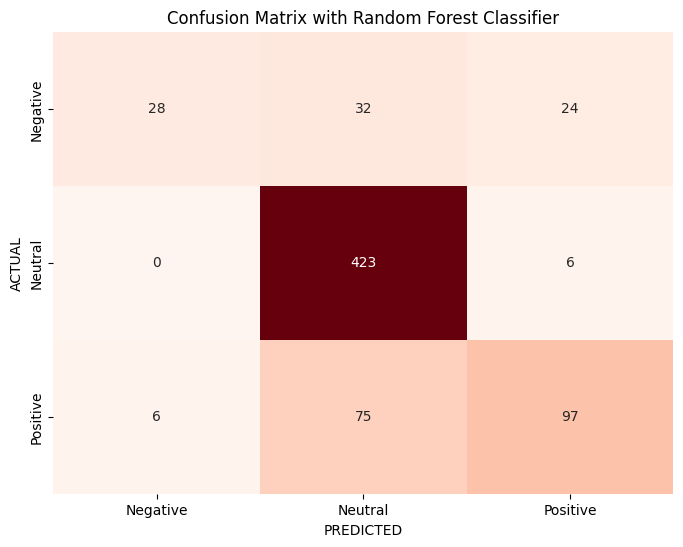

In [ ]:
# to generate a confusion matrix
confusion = confusion_matrix(y_test, y_pred)

# to plot the confusion matrix as a heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(confusion, annot=True, fmt="d", cmap="Reds", cbar=False,
            xticklabels=["Negative", "Neutral", "Positive"],
            yticklabels=["Negative", "Neutral", "Positive"])
plt.xlabel("PREDICTED")
plt.ylabel("ACTUAL")
plt.title("Confusion Matrix with Random Forest Classifier")
plt.savefig("conf_mat_for_rfc.png")
plt.show()

### 4.2. Feature Extraction with Vanilla Neural Network <a class="anchor" id="feature2"></a>


In [ ]:
torch.manual_seed(44)

In [ ]:
class NeuralNetwork(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(NeuralNetwork, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.relu1 = nn.ReLU()                          # ReLU activation for the first hidden layer
        self.fc2 = nn.Linear(hidden_size, hidden_size)  # Second hidden layer
        self.relu2 = nn.ReLU()                          # ReLU activation for the second hidden layer
        self.fc3 = nn.Linear(hidden_size, output_size)  # Output layer

    def forward(self, x):
        out = self.fc1(x)
        out = self.relu1(out)
        out = self.fc2(out)
        out = self.relu2(out)
        out = self.fc3(out)
        return out

In [ ]:
# to convert NumPy arrays to PyTorch tensors
X_train = torch.FloatTensor(X_train)
y_train = torch.LongTensor(y_train)
X_test = torch.FloatTensor(X_test)
y_test = torch.LongTensor(y_test)

In [ ]:
# to define network architecture: input size, hidden size, and output size
input_size = X_train.shape[1]
hidden_size = 128
output_size = 3

In [ ]:
# to define hyperparameter search space

optimizers = {
    'SGD': optim.SGD,
    'Adam': optim.Adam
}

learning_rates = [0.001, 0.01, 0.1]
batch_sizes = [32, 64, 128]

best_accuracy = 0
best_hyperparameters = {}

**Hyperparameter search loop:** Iterates over different combinations of hyperparameters to find the best configuration.

In [ ]:
# Hyperparameter search loop
for optimizer_name, optimizer_class in optimizers.items():
    for lr in learning_rates:
        for batch_size in batch_sizes:
            # initialize an instance of neural network with provided architecture
            model = NeuralNetwork(input_size, hidden_size, output_size)

            # to define loss function
            criterion = nn.CrossEntropyLoss()

            # to initialize optimizer
            optimizer = optimizer_class(model.parameters(), lr=lr)

            # data preparation with PyTorch's TensorDataset and DataLoader
            train_dataset = TensorDataset(X_train, y_train)
            train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

            num_epochs = 10
            for epoch in range(num_epochs):
                model.train()
                for batch_x, batch_y in train_loader:
                    optimizer.zero_grad()
                    outputs = model(batch_x)
                    loss = criterion(outputs, batch_y)
                    loss.backward()
                    optimizer.step()

            # to evaluate neural network on test dataset
            model.eval()
            with torch.no_grad():
                test_outputs = model(X_test)
                test_preds = test_outputs.argmax(dim=1)
                test_accuracy = accuracy_score(y_test.numpy(), test_preds.numpy())

            # to update best performing hyperparameter combination
            if test_accuracy > best_accuracy:

                # to store best accuracy score among iterated models
                best_accuracy = test_accuracy

                # to store best combination's hyperparameters in a dictionary
                best_hyperparameters = {
                    'optimizer': optimizer_name,
                    'learning_rate': lr,
                    'batch_size': batch_size
                }

print(f"""Best hyperparameters: {best_hyperparameters}\nBest validation accuracy: {best_accuracy}""")

Best hyperparameters: {'optimizer': 'Adam', 'learning_rate': 0.001, 'batch_size': 128}
Best validation accuracy: 0.894356005788712


In [ ]:
# now, to create an instance of the neural network using the best combination
best_optimizer = best_hyperparameters['optimizer']
best_lr = best_hyperparameters['learning_rate']
best_batch_size = best_hyperparameters['batch_size']

model = NeuralNetwork(input_size, hidden_size, output_size)

# to initialize optimizer with `Adam`
optimizer = optim.Adam(model.parameters(), lr=best_lr)

# data preparation with PyTorch's TensorDataset and DataLoader
train_dataset = TensorDataset(X_train, y_train)
train_loader = DataLoader(train_dataset, batch_size=best_batch_size, shuffle=True)

# to train the model using the best hyperparameters
num_epochs = 10
for epoch in range(num_epochs):
    model.train()
    for batch_x, batch_y in train_loader:
        optimizer.zero_grad()
        outputs = model(batch_x)
        loss = criterion(outputs, batch_y)
        loss.backward()
        optimizer.step()

# to evaluate the model on test set
model.eval()
with torch.no_grad():
    test_outputs = model(X_test)
    test_predictions = test_outputs.argmax(dim=1)
    test_accuracy = accuracy_score(y_test.numpy(), test_predictions.numpy())

print("Test accuracy with best hyperparameters:", test_accuracy)

Test accuracy with best hyperparameters: 0.8929088277858177


In [ ]:
# to generate classification report
report = classification_report(y_test.numpy(), test_predictions.numpy(), target_names=["Negative", "Neutral", "Positive"])
print("Classification Report:\n", report)

Classification Report:
               precision    recall  f1-score   support

    Negative       0.81      0.74      0.77        84
     Neutral       0.96      0.93      0.94       429
    Positive       0.79      0.88      0.83       178

    accuracy                           0.89       691
   macro avg       0.85      0.85      0.85       691
weighted avg       0.90      0.89      0.89       691



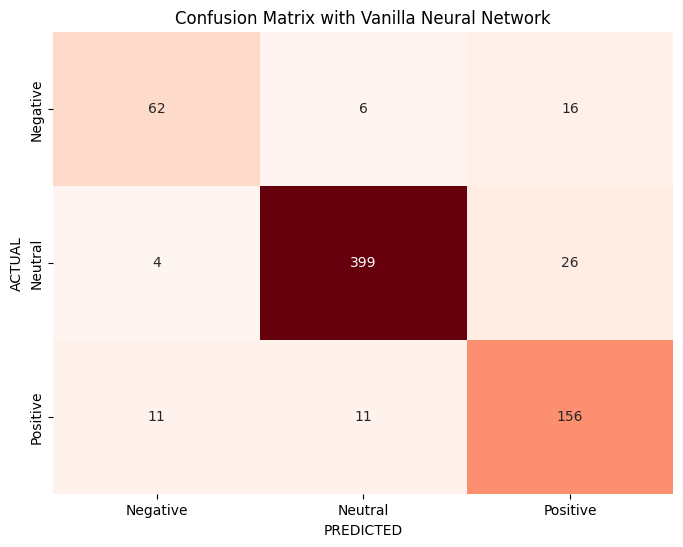

In [ ]:
# to generate confusion matrix
conf_matrix = confusion_matrix(y_test.numpy(), test_predictions.numpy())
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Reds", cbar=False,
            xticklabels=["Negative", "Neutral", "Positive"],
            yticklabels=["Negative", "Neutral", "Positive"])
plt.xlabel("PREDICTED")
plt.ylabel("ACTUAL")
plt.title("Confusion Matrix with Vanilla Neural Network")
plt.savefig("conf_mat_for_nn.png")
plt.show()